<a href="https://colab.research.google.com/github/JuanCuestacode/Proyecto-Base-Datos-Procesos/blob/master/Codigo_Juan_Cuesta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 15 19:52:26 2025

@author: Juan Pablo Cuesta
Librerias:
"""

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta,date
import numpy as np

import seaborn as sns
from sklearn.cluster import KMeans

#import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

#1. Preprocesamiento de los datos y union de tablas



In [ ]:
#%%

#Importar datos de los excels utilizando pandas:
clientes = pd.read_excel('clientes_final.xlsx',sheet_name='Base')
ventas = pd.read_excel('venta_final.xlsx',sheet_name='Base')


# Añadir columna '%desc utilizando una funcion lambda con la formula dada en el archivo de excel
ventas["%desc"] = ventas.apply(lambda row: abs(row["desc"]) / (abs(row["desc"]) + row["nr"]) if (row["desc"] + row["nr"]) != 0 else 0, axis=1)


#Cambiar formato de columna ym a año-mes
ventas['ym']= pd.to_datetime(ventas['ym'].astype(str) , format='%Y%m')
ventas['ym'] = ventas['ym'].dt.to_period('M')


# Realizar el left join para unir la tabla de clientes y ventas
clientes_mas_ventas = pd.merge(clientes, ventas, on='Cliente', how='left')
# Guardar archivo en csv para algunas revisiones
#clientes_mas_ventas.to_csv("ventascondescuentoygerencias.csv", index=False)
#print("\n se guardo el archivo ventascondescuentoygerencias.csv")

#2. Generación de nuevos parámetros


In [ ]:
#%%

#FRECUENCIA DEL CLIENTE

#Se organizan los datos de manera que cada cliente tenga un conjunto de registros para cada mes/año específico en el que hizo compras.
#cuenta el número de registros dentro de cada grupo

frecuencia_compras_por_año = clientes_mas_ventas.groupby(['Cliente']).size().reset_index(name='frecuencia')
print(frecuencia_compras_por_año)

frecuencia_compras_por_mes = clientes_mas_ventas.groupby(['Cliente','ym']).size().reset_index(name='frecuencia')
print(frecuencia_compras_por_mes)

# Calcular el promedio de la frecuencia mensual por cliente
promedio_frecuencia_mensual = frecuencia_compras_por_mes.groupby('Cliente')['frecuencia'].mean().reset_index(name='Promedio Frecuencia Mensual')
print(promedio_frecuencia_mensual)


#Frecuencia por cliente grafico



# plt.figure(figsize=(15, 10))
# plt.scatter(promedio_frecuencia_mensual.index, promedio_frecuencia_mensual['Promedio Frecuencia Mensual'], label='Frecuencia')
# plt.title('Frecuencia de compra por Cliente')
# plt.xlabel('Cliente')
# plt.ylabel('Frecuencia Promedio Por Mes')
# plt.xticks(rotation=45)
# plt.legend()
# plt.grid(axis='x')
# plt.tight_layout()
# plt.show()
#-------------------------------------------------------------

#Recencia del cliente
# Recencia Calcularemos los meses transcurridos desde la última compra por cada uno de los clientes

# Obtener la fecha más reciente del dataset
fecha_mas_reciente = clientes_mas_ventas['ym'].max()
print("Fecha más reciente del dataset:", fecha_mas_reciente)
# Ordenar los datos por cliente y fecha de venta
clientes_mas_ventas = clientes_mas_ventas.sort_values(by=['Cliente', 'ym'], ascending=[True, False])
print(clientes_mas_ventas.head())

# Rankear las fechas más recientes por cliente
clientes_mas_ventas['rank'] = clientes_mas_ventas.groupby('Cliente')['ym'].rank(method='first', ascending=False)

# Filtrar solo las filas con las fechas más recientes (esto sigue el orden de las fechas)
clientes_mas_ventas_top1 = clientes_mas_ventas[clientes_mas_ventas['rank'] == 1].copy()  # Solo clientes con 1 fecha más reciente

# Reorganizar las fechas de cada cliente en columnas separadas (aquí cada cliente solo tendrá una fecha)
clientes_mas_ventas_recencia = clientes_mas_ventas_top1.groupby('Cliente')['ym'].agg(list).reset_index()

# Asegurarnos de que cada cliente tiene exactamente una fecha
clientes_mas_ventas_recencia = clientes_mas_ventas_recencia[clientes_mas_ventas_recencia['ym'].apply(len) == 1]

# Calcular la diferencia en meses entre la fecha más reciente del dataset y la fecha más reciente de cada cliente
def diferencia_meses(fechas):
    return (fecha_mas_reciente.year - fechas[0].year) * 12 + (fecha_mas_reciente.month - fechas[0].month)

clientes_mas_ventas_recencia['recencia'] = clientes_mas_ventas_recencia['ym'].apply(diferencia_meses)

print(clientes_mas_ventas_recencia[['Cliente', 'recencia']])


# plt.figure(figsize=(12, 6))
# plt.scatter(clientes_mas_ventas_recencia.index, clientes_mas_ventas_recencia['recencia'])
# plt.title('Recencia de compra por Cliente')
# plt.xlabel('Cliente')
# plt.ylabel('Recencia Promedio Por Mes')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


#------------------------------------------------------------------------------------------------------------------

#Monetizacion
# Calcular la Monetización (NetRevenue total por cliente)
clientes_mas_ventas_monetizacion = clientes_mas_ventas.groupby('Cliente')['nr'].sum().reset_index()
clientes_mas_ventas_monetizacion.rename(columns={'nr': 'monetizacion'}, inplace=True)

print(clientes_mas_ventas_monetizacion)


#-------------------------------------------------------------
# Combinar Recencia, Frecuencia y Monetización
tablafinal = pd.merge(clientes_mas_ventas_recencia[['Cliente', 'recencia']], promedio_frecuencia_mensual, on='Cliente')
tablafinal = pd.merge(tablafinal, clientes_mas_ventas_monetizacion, on='Cliente')


      Cliente  frecuencia
0        cte1          44
1       cte10         107
2      cte100         113
3     cte1000          37
4     cte1001          44
...       ...         ...
2856   cte995          78
2857   cte996          12
2858   cte997         184
2859   cte998          71
2860   cte999          26

[2861 rows x 2 columns]
      Cliente       ym  frecuencia
0        cte1  2023-01           1
1        cte1  2023-02           2
2        cte1  2023-03           2
3        cte1  2023-04           2
4        cte1  2023-05           2
...       ...      ...         ...
33777  cte999  2023-03           4
33778  cte999  2023-04           4
33779  cte999  2023-05           3
33780  cte999  2023-06           4
33781  cte999  2023-07           2

[33782 rows x 3 columns]
      Cliente  Promedio Frecuencia Mensual
0        cte1                     2.444444
1       cte10                     5.944444
2      cte100                     6.277778
3     cte1000                     2.055556
4 

#3. Generación de gráficos


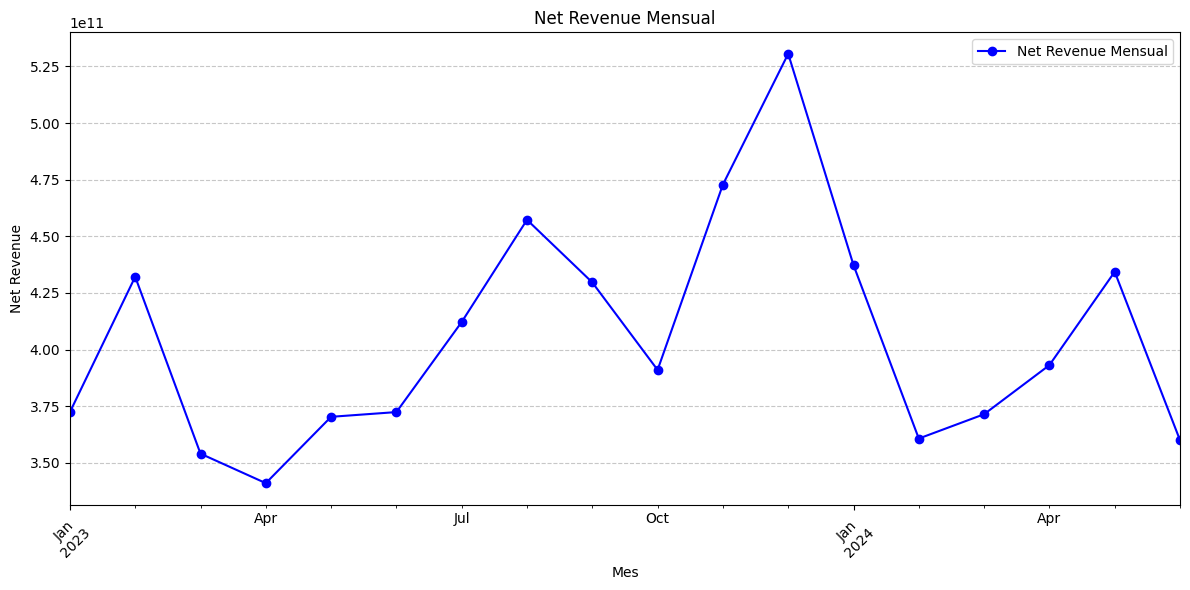

<Figure size 1200x800 with 0 Axes>

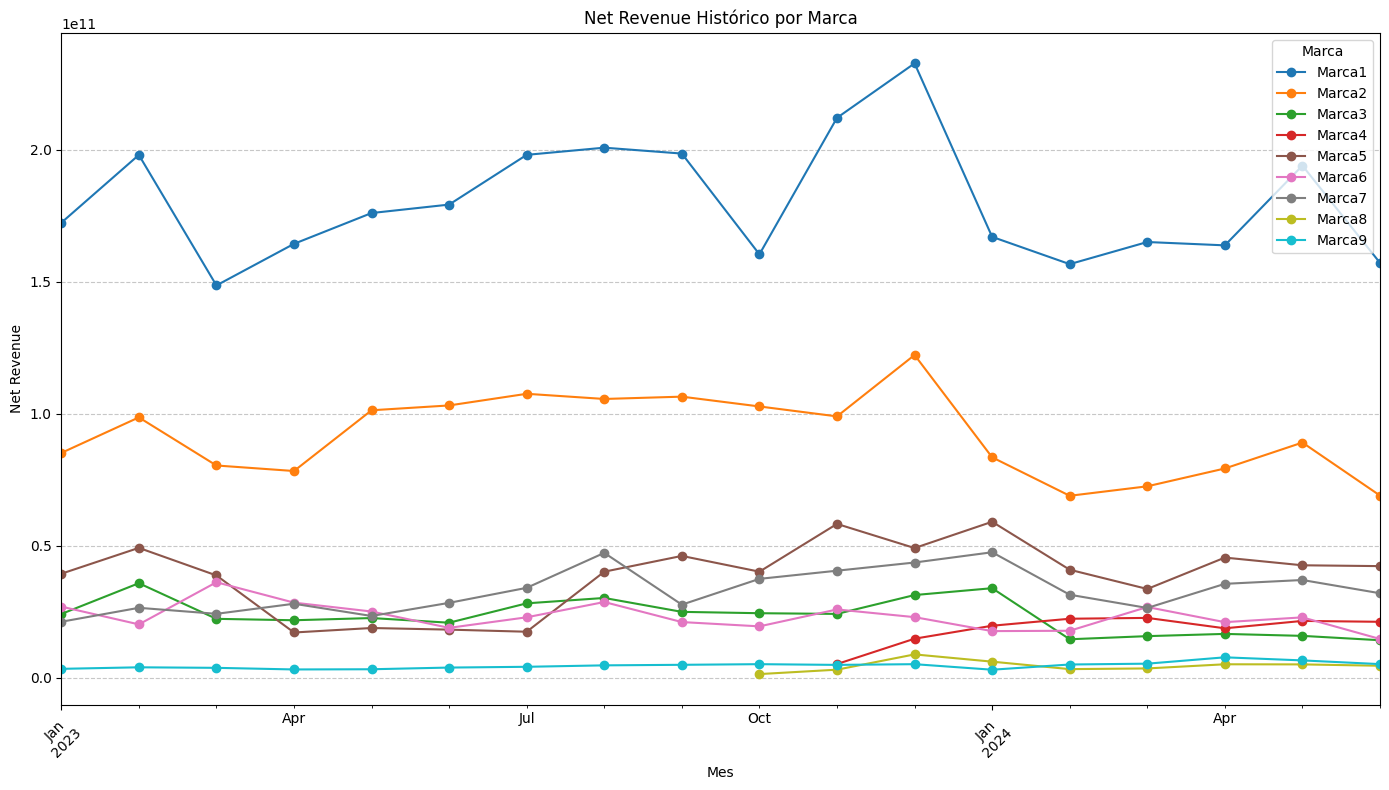

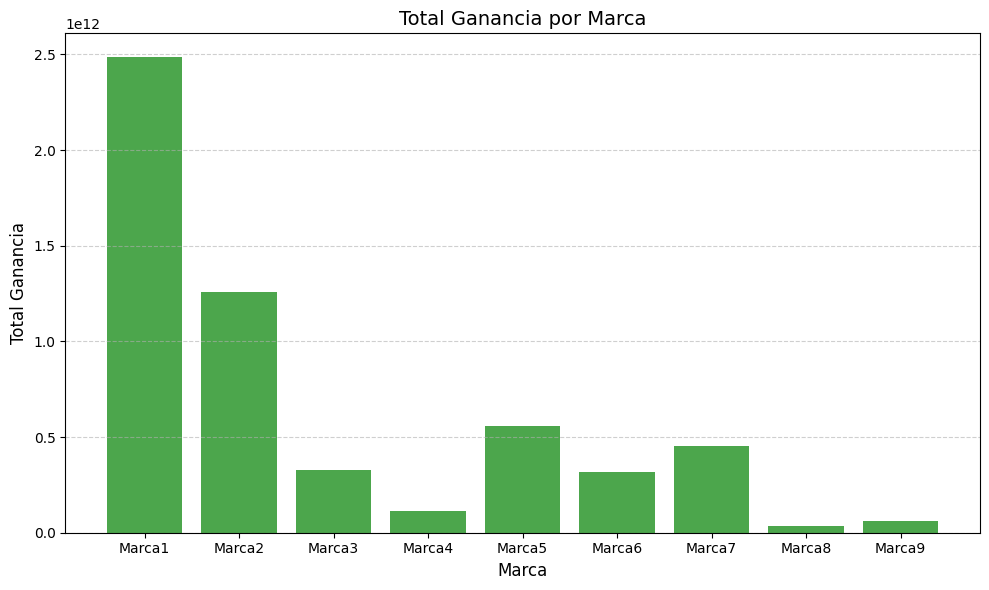

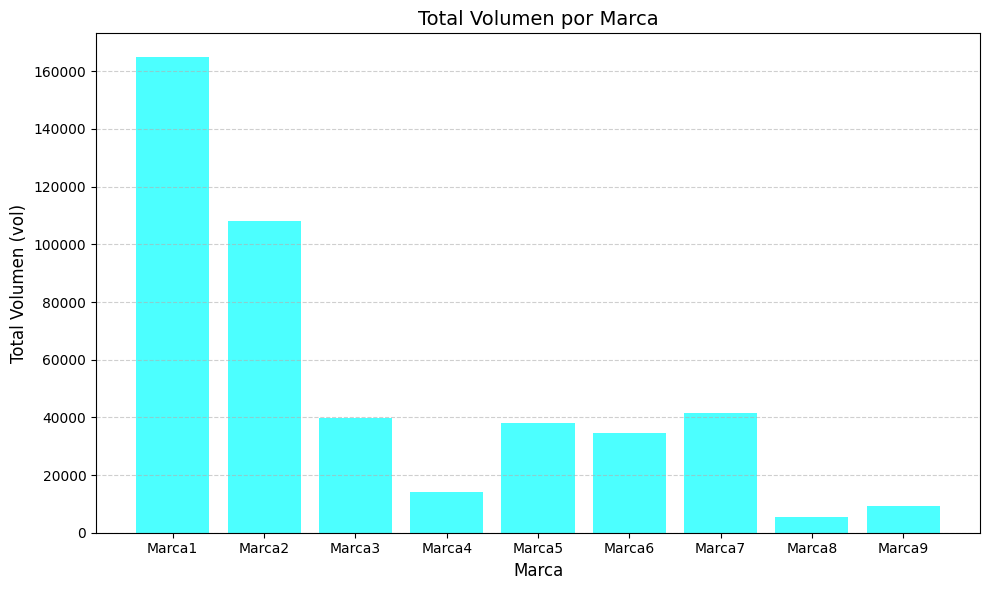

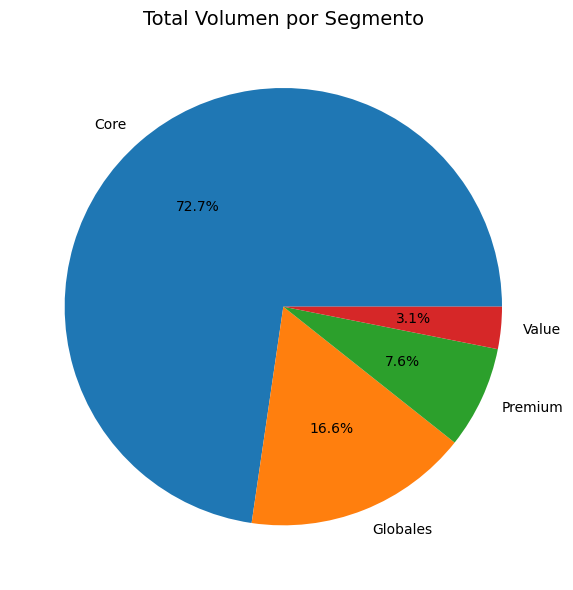

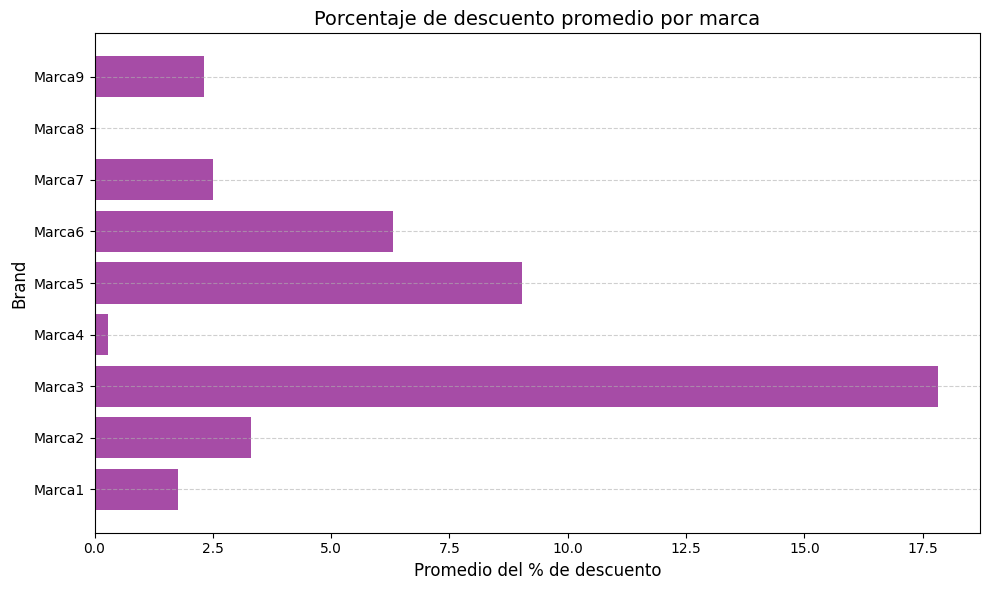

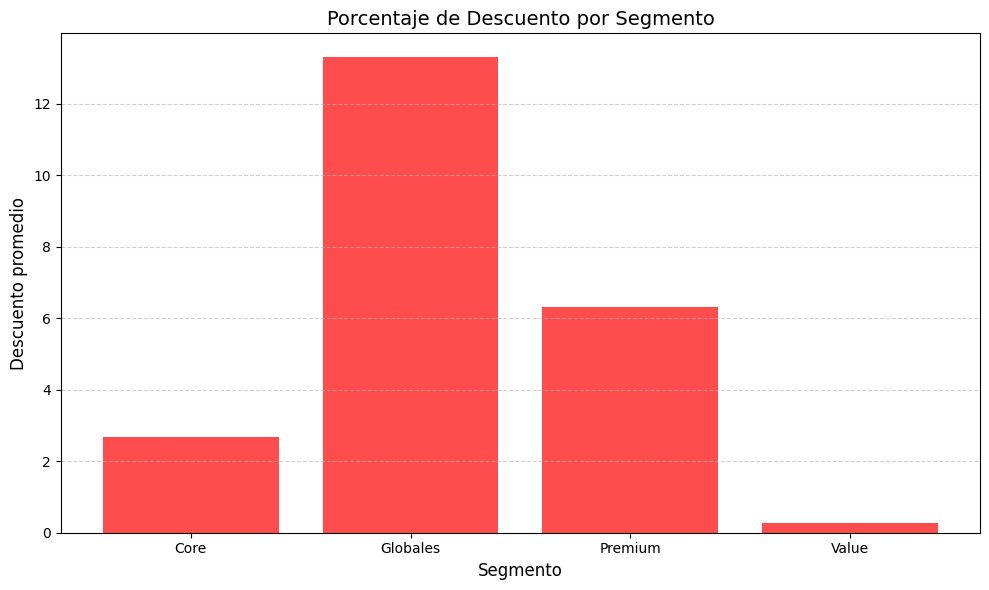

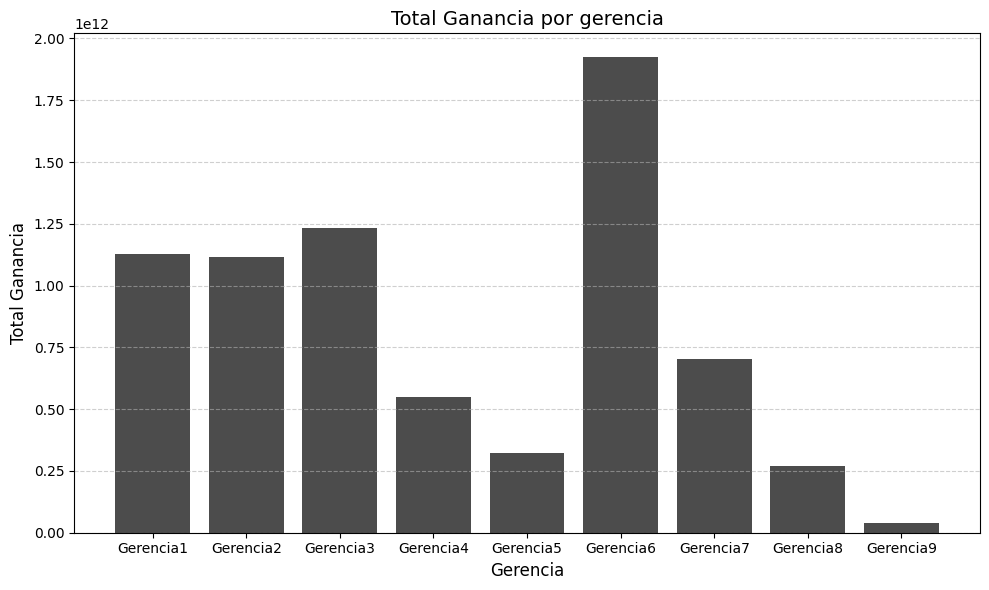

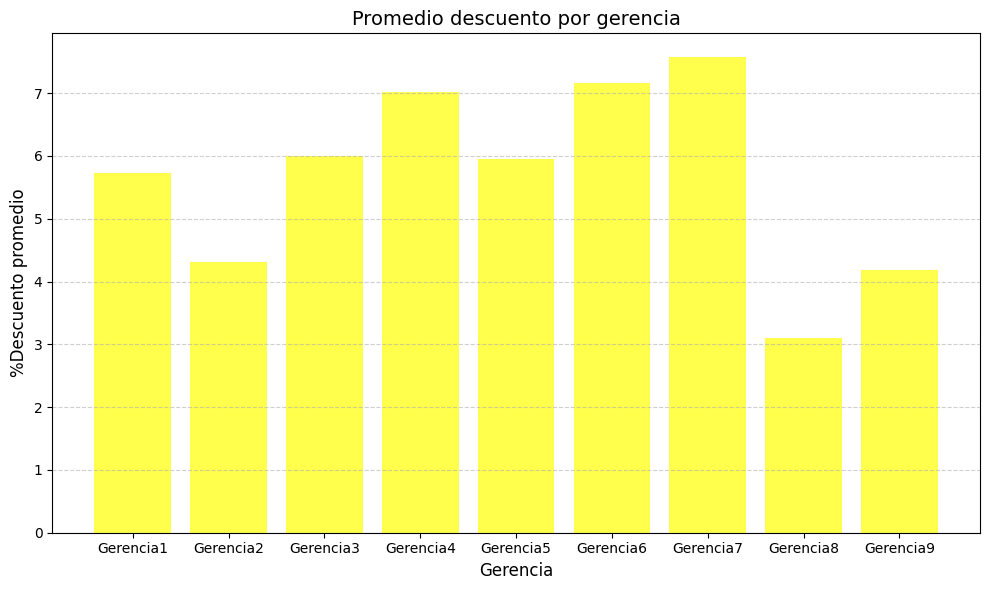

In [ ]:
#%%

# Graficos ------------------------------------------------------------------------
#Agrupar por mes y calcular el Net Revenue total por mes
clientes_mas_ventas_mes = clientes_mas_ventas

net_revenue_mensual = clientes_mas_ventas.groupby('ym')['nr'].sum()

#Graficar el Net Revenue por mes
plt.figure(figsize=(12, 6))
net_revenue_mensual.plot(kind='line', marker='o', color='blue', label='Net Revenue Mensual')
plt.title('Net Revenue Mensual')
plt.xlabel('Mes')
plt.ylabel('Net Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#-----------------------------------

#Net Revenue Historico por Marca
net_revenue_por_marca = clientes_mas_ventas.groupby(['ym','brand'])['nr'].sum().unstack()

#Graficar el Net Revenue por marca/mes
plt.figure(figsize=(12, 8))
net_revenue_por_marca.plot(kind='line', marker='o', figsize=(14, 8), cmap='tab10')
plt.title('Net Revenue Histórico por Marca')
plt.xlabel('Mes')
plt.ylabel('Net Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Marca')
plt.tight_layout()
plt.show()
#----------------------------------------------
#Ganancia total por marca sin descuentos
plt.figure(figsize=(10, 6))
ventas_agrupadas_por_marca_ganancia = ventas.groupby("brand")["nr"].sum().reset_index()
plt.bar(ventas_agrupadas_por_marca_ganancia["brand"], ventas_agrupadas_por_marca_ganancia["nr"], color="green", alpha=0.7)
plt.title("Total Ganancia por Marca", fontsize=14)
plt.xlabel("Marca", fontsize=12)
plt.ylabel("Total Ganancia", fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
#-------------------------------------------------------------
#Volumen total por marca
plt.figure(figsize=(10, 6))
ventas_agrupadas_por_marca = ventas.groupby("brand")["vol"].sum().reset_index()
plt.bar(ventas_agrupadas_por_marca["brand"], ventas_agrupadas_por_marca["vol"], color="cyan", alpha=0.7)
plt.title("Total Volumen por Marca", fontsize=14)
plt.xlabel("Marca", fontsize=12)
plt.ylabel("Total Volumen (vol)", fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#-------------------------------------------------------------
#Volumen total por Segmento
plt.figure(figsize=(10, 6))
ventas_agrupadas_por_segmento_vol = ventas.groupby("segment")["vol"].sum().reset_index()
plt.pie(ventas_agrupadas_por_segmento_vol["vol"],labels= ventas_agrupadas_por_segmento_vol["segment"], autopct = '%1.1f%%')
plt.title("Total Volumen por Segmento", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#-------------------------------------------------------------
#Utilizando la media de descuentos por marca:
plt.figure(figsize=(10, 6))
ventas_agrupadas_por_marca2 = ventas.groupby("brand")["%desc"].mean().reset_index()
plt.barh(ventas_agrupadas_por_marca2["brand"], ventas_agrupadas_por_marca2["%desc"]*100, color="purple", alpha=0.7)
plt.title("Porcentaje de descuento promedio por marca", fontsize=14)
plt.xlabel("Promedio del % de descuento", fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#-------------------------------------------------------------
#Utilizando la media de descuentos por segmento  Hay un problema en el la data del 4 marca segmento:
plt.figure(figsize=(10, 6))
ventas_agrupadas_por_segmento = ventas.groupby("segment")["%desc"].mean().reset_index()
plt.bar(ventas_agrupadas_por_segmento["segment"], ventas_agrupadas_por_segmento["%desc"]*100, color="red", alpha=0.7)
plt.title("Porcentaje de Descuento por Segmento", fontsize=14)
plt.xlabel("Segmento", fontsize=12)
plt.ylabel("Descuento promedio", fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



#-------------------------------------------------------------
#AHORA GRAFICOS DE DATOS CRUZADOS
#Ganancia total por gerencia
plt.figure(figsize=(10, 6))
gerencia_por_ganancias = clientes_mas_ventas.groupby("Gerencia")["nr"].sum().reset_index()
plt.bar(gerencia_por_ganancias["Gerencia"], gerencia_por_ganancias["nr"], color="black", alpha=0.7)
plt.title("Total Ganancia por gerencia", fontsize=14)
plt.xlabel("Gerencia", fontsize=12)
plt.ylabel("Total Ganancia", fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#Descuento promedio mas alto por gerencia
plt.figure(figsize=(10, 6))
gerencia_por_descuento = clientes_mas_ventas.groupby("Gerencia")["%desc"].mean().reset_index()
plt.bar(gerencia_por_descuento["Gerencia"], gerencia_por_descuento["%desc"]*100, color="yellow", alpha=0.7)
plt.title("Promedio descuento por gerencia", fontsize=14)
plt.xlabel("Gerencia", fontsize=12)
plt.ylabel("%Descuento promedio", fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#4. Método del Codo aplicado a RFM para análisis de segmentación de clientes


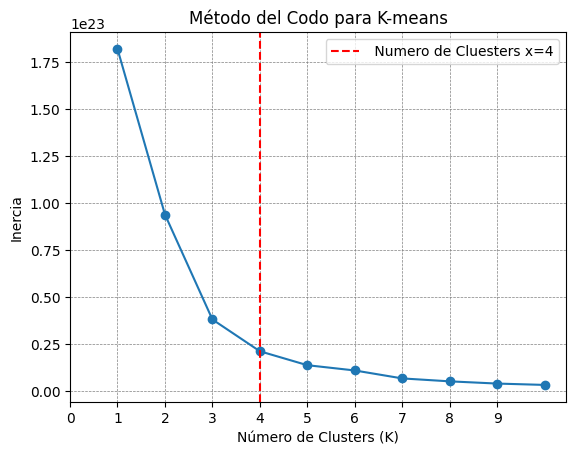

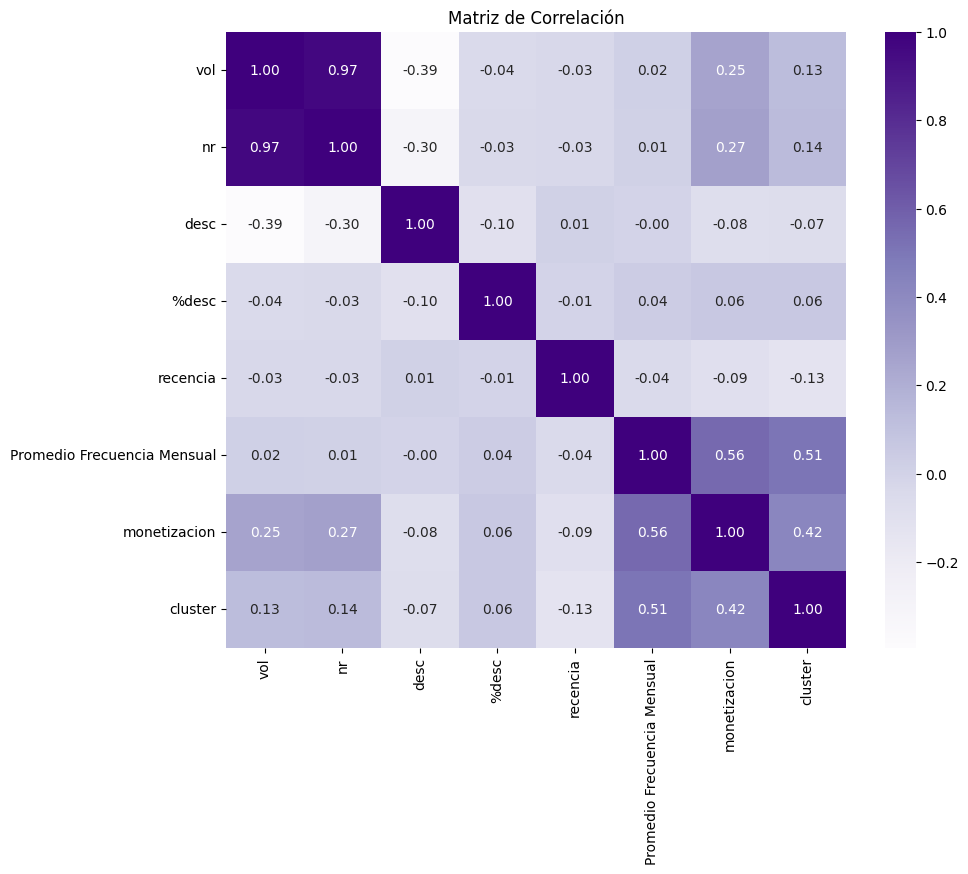

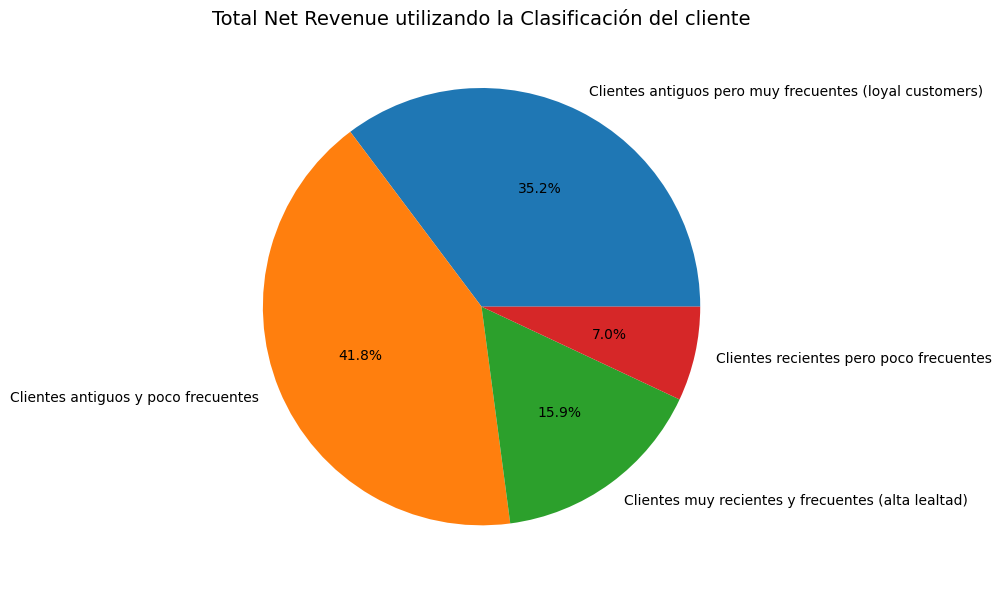

In [ ]:
#La idea es clasificar los clientes en los siguientes tipos:
#Clientes muy recientes y frecuentes: Se consideran clientes altamente leales, propensos a recibir ofertas de recompensas o programas de fidelización.
#Clientes recientes pero poco frecuentes: Pueden recibir promociones para incentivar más compras.
#Clientes antiguos y poco frecuentes: Son los que pueden necesitar estrategias de reactivación, como descuentos atractivos.


#Segmentación con el Método del Codo
# Seleccionar las columnas R, F, M para clustering
X = tablafinal[['recencia', 'Promedio Frecuencia Mensual', 'monetizacion']]

# Método del Codo para determinar el número óptimo de clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
fig, ax = plt.subplots()
ax.plot(K_range, inertia, marker='o')
all_ticks = np.arange(0, 10)  # Genera números del 0 al 9
ax.set_xticks(all_ticks)
ax.axvline(x=4, color='red', linestyle='--', label=' Numero de Cluesters x=4')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-means')
# Agregar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # Personaliza la cuadrícula
# Mostrar la leyenda
plt.legend()
plt.show()

#Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
tablafinal['cluster'] = kmeans.fit_predict(X)



# Asignar etiquetas a los clusters
def clasificar_cliente(cluster):
    if cluster == 0:
        return 'Clientes antiguos y poco frecuentes'
    elif cluster == 1:
        return 'Clientes recientes pero poco frecuentes'
    elif cluster == 2:
        return 'Clientes muy recientes y frecuentes (alta lealtad)'
    elif cluster == 3:
        return 'Clientes antiguos pero muy frecuentes (loyal customers)'

# Aplicar la clasificación
tablafinal['clasificacion_cliente'] = tablafinal['cluster'].apply(clasificar_cliente)
# guardar archivo en csv para algunas revisiones
tablafinal.to_csv("TiposdeClientes.csv", index=False)
#%%
#Otros Graficos:
#Correlación de datos
# Filtrar las columnas numéricas

# Realizar el left join para unir la tabla de clientes y ventas
clientes_mas_ventas = pd.merge(clientes_mas_ventas.drop(columns=['rank']), tablafinal, on='Cliente', how='left')
numeric_columns = clientes_mas_ventas.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Graficar la matriz de correlación con un heatmap Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Purples", cbar=True)
plt.title("Matriz de Correlación")
plt.show()



#Volumen total por marca
plt.figure(figsize=(10, 6))
ventas_clasificadas_cliente = clientes_mas_ventas.groupby("clasificacion_cliente")["nr"].sum().reset_index()
plt.pie(ventas_clasificadas_cliente["nr"],labels= ventas_clasificadas_cliente["clasificacion_cliente"], autopct = '%1.1f%%')
plt.title("Total Net Revenue utilizando la Clasificación del cliente", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# 5.Generación del modelo de probabilidad


Confusión Matrix:
[[217  47]
 [  0 309]]


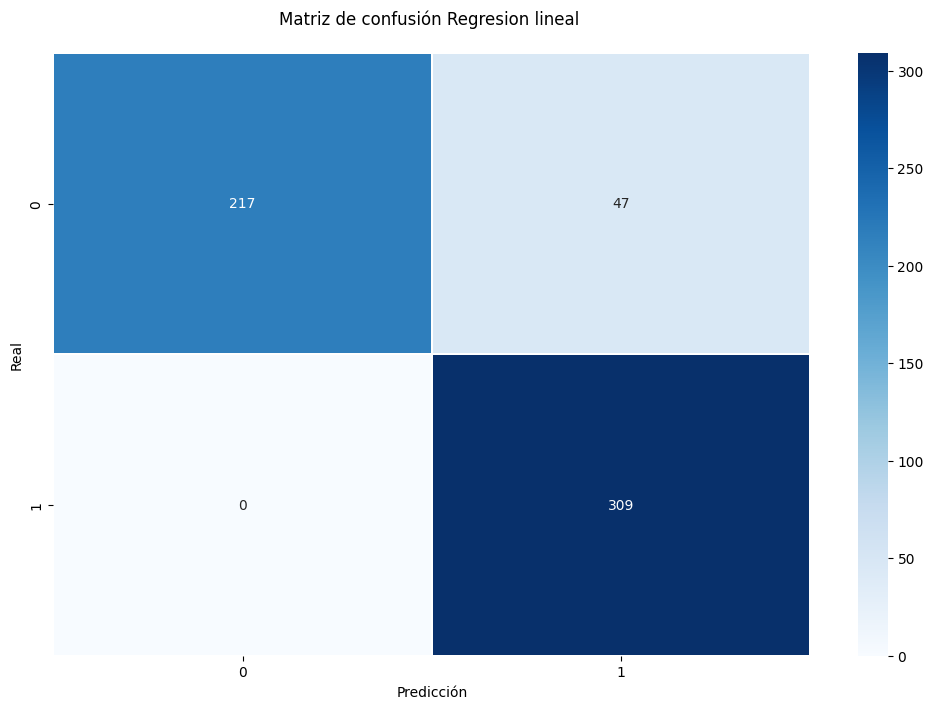


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       264
           1       0.87      1.00      0.93       309

    accuracy                           0.92       573
   macro avg       0.93      0.91      0.92       573
weighted avg       0.93      0.92      0.92       573



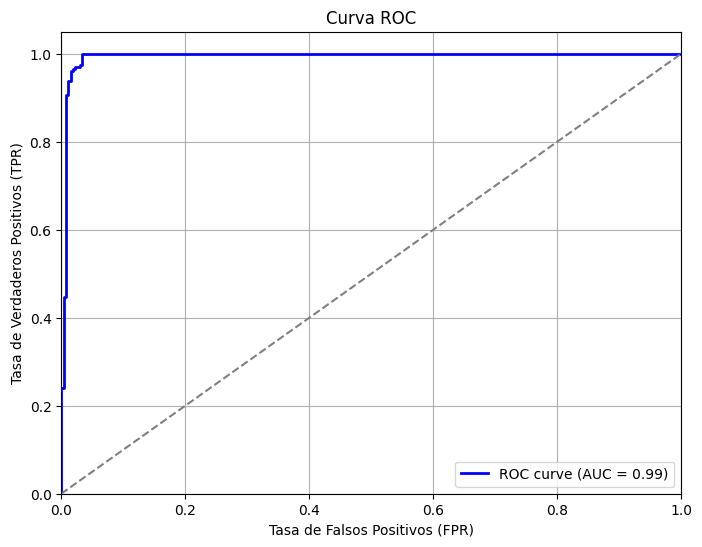

Predicciones para nuevos datos: [0 0 1]
Probabilidades para nuevos datos:
 [[9.89414997e-01 1.05850033e-02]
 [8.41437313e-01 1.58562687e-01]
 [2.93266812e-07 9.99999707e-01]]
Confusión Matrix:
[[1224  128]
 [   0 6661]]


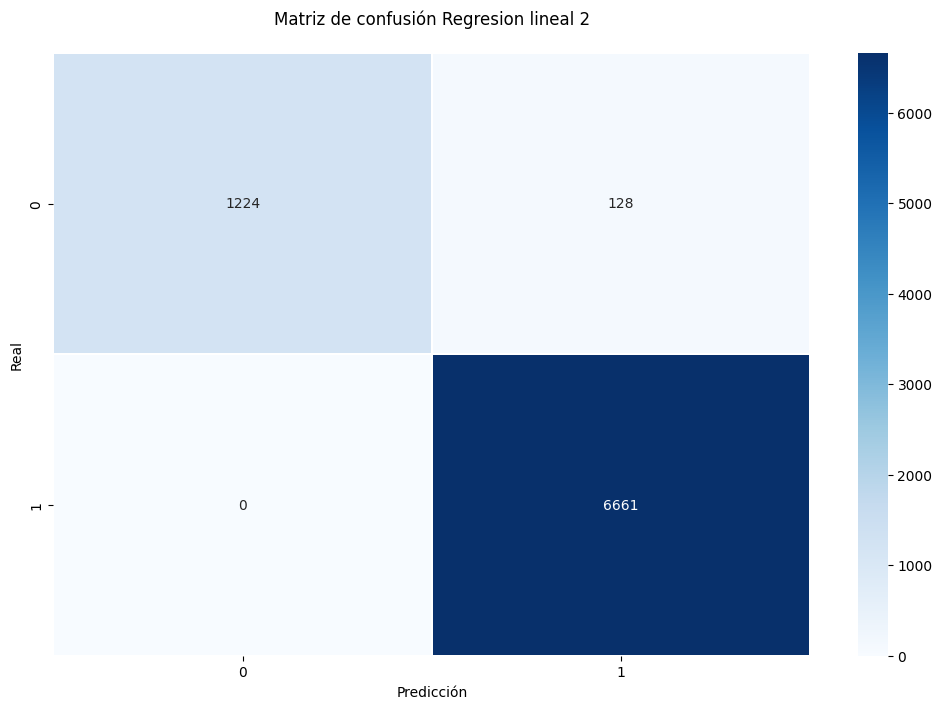


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1352
           1       0.98      1.00      0.99      6661

    accuracy                           0.98      8013
   macro avg       0.99      0.95      0.97      8013
weighted avg       0.98      0.98      0.98      8013



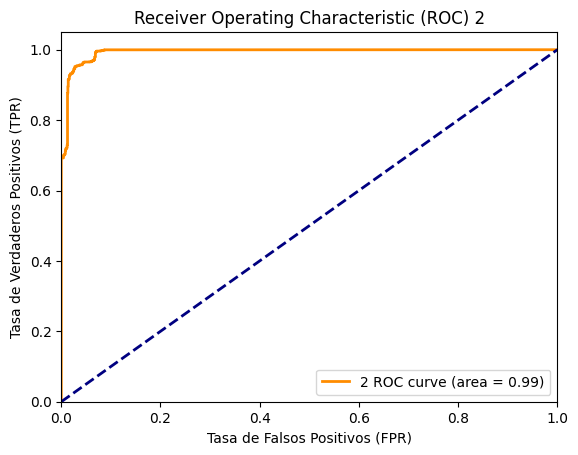

Predicciones para nuevos datos:
 [0 0 1]
Probabilidades para nuevos datos 
: [[9.99932492e-01 6.75076784e-05]
 [8.30215552e-01 1.69784448e-01]
 [9.25695338e-06 9.99990743e-01]]
Confusion Matrix:
[[1529    0]
 [   0 7552]]


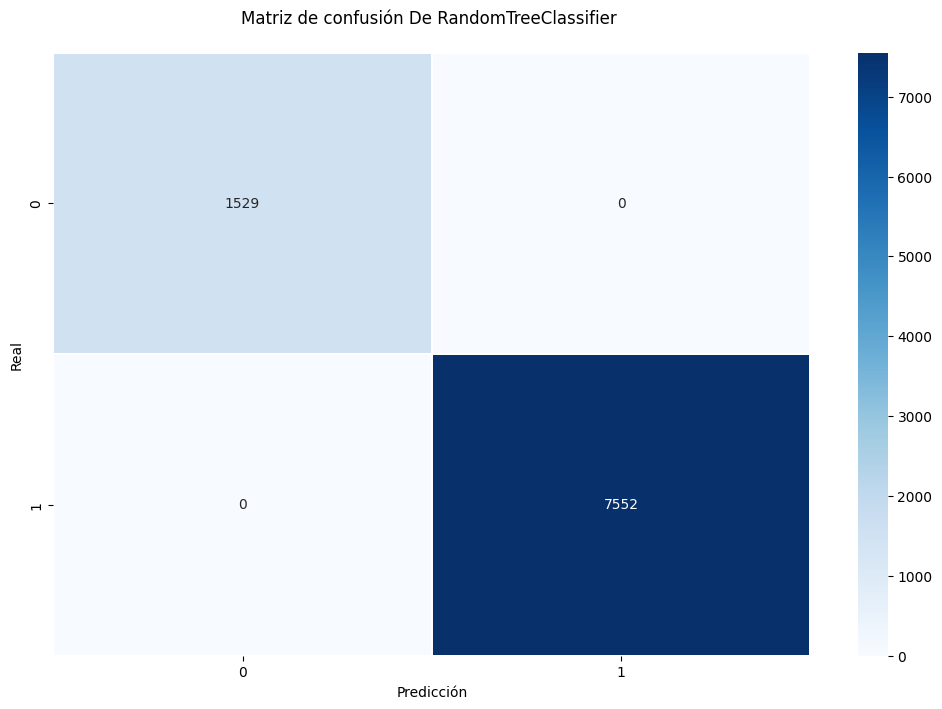


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1529
           1       1.00      1.00      1.00      7552

    accuracy                           1.00      9081
   macro avg       1.00      1.00      1.00      9081
weighted avg       1.00      1.00      1.00      9081



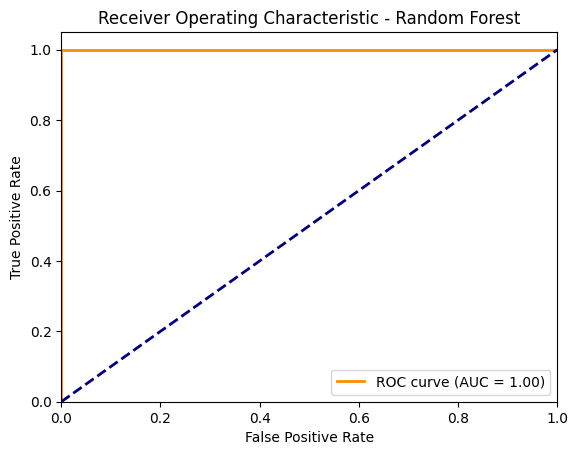

Predicciones para nuevos datos: [0 0 1]
Probabilidades para nuevos datos: [0.   0.01 0.99]


In [ ]:
#%%
#------------------------------------------------------------
# Filtrar la tabla para que solo contenga las filas donde la marca es "marca3"
clientes_mas_ventas = clientes_mas_ventas[clientes_mas_ventas['brand'] == 'Marca3']


#%%
# Crear una variable objetivo: ¿Comprará en el siguiente mes? (1 = sí, 0 = no)
# Supongamos que si la recencia es menor a un 1 mes y el promedio de Frecuencia mensual de compra es Mayor a 2,
#el cliente probablemente comprará.

tablafinal['compra_proxima'] = ((tablafinal['recencia'] < 1) &
                                 (tablafinal['Promedio Frecuencia Mensual'] > 2)).astype(int)
# Dividir los datos en características (X) y objetivo (y)
X = tablafinal[['recencia', 'Promedio Frecuencia Mensual', 'monetizacion']]
y = tablafinal['compra_proxima']




# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1 (comprará)

# Evaluar el modelo
print("Confusión Matrix:")
print(confusion_matrix(y_test, y_pred))

matriz_de_confusion= confusion_matrix(y_test,y_pred)
dataframe_matriz = pd.DataFrame(matriz_de_confusion)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe_matriz,
            annot = True,
            cbar = True,
            linewidths=0.1,
            fmt=".0f",
            cmap="Blues"
            )
plt.title("Matriz de confusión Regresion lineal \n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calcular y graficar la AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (aleatoria)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





#Prueba del modelo:

# Supongamos que tienes un nuevo DataFrame con datos de clientes

nuevos_datos = pd.DataFrame({
    'recencia': [2,1,0],
    'Promedio Frecuencia Mensual': [2,3,5],
    'monetizacion': [0,30060195,50423540000]
})
#Interpretación:
#La primera columna representa la probabilidad de que el cliente no compre (clase 0).
#La segunda columna representa la probabilidad de que el cliente compre (clase 1).

# Estandarizar los nuevos datos
nuevos_datos_scaled = scaler.transform(nuevos_datos)

# Hacer predicciones sobre los nuevos datos
predicciones_nuevas = model.predict(nuevos_datos_scaled)
probabilidades_nuevas = model.predict_proba(nuevos_datos_scaled)

print("Predicciones para nuevos datos:", predicciones_nuevas)
print("Probabilidades para nuevos datos:\n", probabilidades_nuevas)

#-----------------------------------------------------------------------------------------
#%%
# Evidenciando la probabilidad de compra por cada cliente para la marca 3.
# Supongamos que si la recencia es menor a un 1 mes y el promedio de Frecuencia mensual de compra es Mayor a 2,
#el cliente probablemente comprará.
tablafinal=[]
tablafinal = pd.merge(clientes_mas_ventas_recencia[['Cliente', 'recencia']], promedio_frecuencia_mensual, on='Cliente')
tablafinal = pd.merge(tablafinal, clientes_mas_ventas_monetizacion, on='Cliente')
tablafinal=pd.merge(tablafinal,clientes_mas_ventas[['Cliente','Gerencia','subcanal']], on='Cliente')
tablafinal['compra_proxima'] = ((tablafinal['recencia'] < 1) &
                                 (tablafinal['Promedio Frecuencia Mensual'] > 2)).astype(int)

# Dividir los datos en características (X) y objetivo (y)
X2 = tablafinal[['Gerencia','subcanal','recencia', 'Promedio Frecuencia Mensual', 'monetizacion']]
X2 = pd.get_dummies(X2, columns=['Gerencia', 'subcanal'], drop_first=True)
y2 = tablafinal['compra_proxima']
columnas_entrenamiento = X2.columns.tolist()


# Dividir los datos en entrenamiento y prueba
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)


# Estandarizar los datos
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

# Guardar las columnas del entrenamiento

# Crear y entrenar el modelo de regresión logística
model2Regresion = LogisticRegression()
model2Regresion.fit(X2_train, y2_train)

# Hacer predicciones
y2_pred = model2Regresion.predict(X2_test)
y2_prob = model2Regresion.predict_proba(X2_test)[:, 1]  # Probabilidades de la clase 1 (comprará)

# Evaluar el modelo
print("Confusión Matrix:")
print(confusion_matrix(y2_test, y2_pred))

matriz_de_confusion2= confusion_matrix(y2_test,y2_pred)
dataframe_matriz2 = pd.DataFrame(matriz_de_confusion2)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe_matriz2,
            annot = True,
            cbar = True,
            linewidths=0.1,
            fmt=".0f",
            cmap="Blues"
            )
plt.title("Matriz de confusión Regresion lineal 2\n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

print("\nClassification Report:")
print(classification_report(y2_test, y2_pred))

# Calcular y graficar la AUC-ROC
roc_auc = roc_auc_score(y2_test, y2_prob)
fpr, tpr, _ = roc_curve(y2_test, y2_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='2 ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Receiver Operating Characteristic (ROC) 2')
plt.legend(loc="lower right")
plt.show()





#Prueba del modelo:

# Supongamos que tienes un nuevo DataFrame con datos de clientes

nuevos_datos = pd.DataFrame({
   'Gerencia':['Gerencia2','Gerencia5','Gerencia7'],
   'subcanal':['tiendita','tiendita','tiendita'],
   'recencia': [2,1,0],
   'Promedio Frecuencia Mensual': [2,3,5],
   'monetizacion': [0,30060195,50423540000]
})
#Interpretación:
#La primera columna representa la probabilidad de que el cliente no compre (clase 0).
#La segunda columna representa la probabilidad de que el cliente compre (clase 1).

# Estandarizar los nuevos datos
nuevos_datos = pd.get_dummies(nuevos_datos, columns=['Gerencia', 'subcanal'], drop_first=True)
# Asegúrate de que las columnas coincidan con las del entrenamiento
nuevos_datos = nuevos_datos.reindex(columns=columnas_entrenamiento, fill_value=0)
nuevos_datos_scaled = scaler.transform(nuevos_datos)

# Hacer predicciones sobre los nuevos datos
predicciones_nuevas = model2Regresion.predict(nuevos_datos_scaled)
probabilidades_nuevas = model2Regresion.predict_proba(nuevos_datos_scaled)

print("Predicciones para nuevos datos:\n", predicciones_nuevas)
print("Probabilidades para nuevos datos \n:", probabilidades_nuevas)

#-------------------------------------------------------------------------
# Dividir los datos en características (X) y objetivo (y)
#X = tablafinal[['recencia', 'Promedio Frecuencia Mensual', 'monetizacion']]
#y = tablafinal['compra_proxima']
# %%
# Supongamos que si la recencia es menor a un 1 mes y el promedio de Frecuencia mensual de compra es Mayor a 2,
#el cliente probablemente comprará.
tablafinal=[]
tablafinal = pd.merge(clientes_mas_ventas_recencia[['Cliente', 'recencia']], promedio_frecuencia_mensual, on='Cliente')
tablafinal = pd.merge(tablafinal, clientes_mas_ventas_monetizacion, on='Cliente')
tablafinal=pd.merge(tablafinal,clientes_mas_ventas[['Cliente','Gerencia','subcanal']], on='Cliente')
tablafinal['compra_proxima'] = ((tablafinal['recencia'] < 1) &
                                 (tablafinal['Promedio Frecuencia Mensual'] > 2)).astype(int)




X3 = tablafinal[['Gerencia','subcanal','recencia', 'Promedio Frecuencia Mensual', 'monetizacion']]
le = LabelEncoder()
# Usar .loc para asignar la transformación
X3.loc[:, 'Gerencia'] = le.fit_transform(X3['Gerencia'])
X3.loc[:, 'subcanal'] = le.fit_transform(X3['subcanal'])


y3 = tablafinal['compra_proxima']

# Dividir los datos en entrenamiento y prueba
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.34, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X3_train = scaler.fit_transform(X3_train)
X3_test = scaler.transform(X3_test)


# 1. Entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X3_train, y3_train)

# 2. Realizar predicciones
y3_pred_rf = rf_model.predict(X3_test)  # Predicciones binarias (0 o 1)
y3_prob_rf = rf_model.predict_proba(X3_test)[:, 1]  # Probabilidad de la clase positiva

# 3. Crear un DataFrame con resultados
df_results = pd.DataFrame({
    'compra_futura_real': y3_test.values,  # Etiquetas reales
    'compra_futura_pred': y3_pred_rf,     # Predicciones binarias
    'probabilidad_compra': y3_prob_rf    # Probabilidades predichas
})

# 4. Mostrar métricas de evaluación
print("Confusion Matrix:")
print(confusion_matrix(y3_test, y3_pred_rf))

matriz_de_confusion3= confusion_matrix(y3_test,y3_pred_rf)
dataframe_matriz3 = pd.DataFrame(matriz_de_confusion3)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe_matriz3,
            annot = True,
            cbar = True,
            linewidths=0.1,
            fmt=".0f",
            cmap="Blues"
            )
plt.title("Matriz de confusión De RandomTreeClassifier \n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

print("\nClassification Report:")
print(classification_report(y3_test, y3_pred_rf))

# 5. Calcular y graficar la AUC-ROC
roc_auc_rf = roc_auc_score(y3_test, y3_prob_rf)
fpr_rf, tpr_rf, _ = roc_curve(y3_test, y3_prob_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

nuevos_datos = pd.DataFrame({
    'Gerencia':['Gerencia2','Gerencia5','Gerencia7'],
    'subcanal':['tiendita','tiendita','tiendita'],
    'recencia': [2,1,0],
    'Promedio Frecuencia Mensual': [2,3,5],
    'monetizacion': [0,30060195,50423540000]
})


nuevos_datos.loc[:, 'Gerencia'] = le.fit_transform(nuevos_datos['Gerencia'])
nuevos_datos.loc[:, 'subcanal'] = le.fit_transform(nuevos_datos['subcanal'])
nuevos_datos = scaler.fit_transform(nuevos_datos)

predicciones_nuevas_randomF = rf_model.predict(nuevos_datos)  # Predicciones binarias (0 o 1)
probabilidad_nueva_data_radomF = rf_model.predict_proba(nuevos_datos)[:, 1]  # Probabilidad de la clase positiva

print("Predicciones para nuevos datos:", predicciones_nuevas_randomF)
print("Probabilidades para nuevos datos:", probabilidad_nueva_data_radomF)